In [1]:
!git clone https://github.com/ChandraMohan21/lstm-cnn-bwo-energy-prediction

Cloning into 'lstm-cnn-bwo-energy-prediction'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5/5), done.


In [8]:
# %cd lstm-cnn-bwo-energy-prediction
# !mkdir data notebooks src results
# !mv cnn_lstm_bwo.ipynb notebooks/
# !ls
!ls /content


drive  lstm-cnn-bwo-energy-prediction  sample_data


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random



X_train = np.load("/content/drive/MyDrive/LSTM PAPER/X_train.npy")
X_test  = np.load("/content/drive/MyDrive/LSTM PAPER/X_test.npy")
y_train = np.load("/content/drive/MyDrive/LSTM PAPER/y_train.npy")
y_test  = np.load("/content/drive/MyDrive/LSTM PAPER/y_test.npy")

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]

POP_SIZE = 10
ITERATIONS = 15

PARAM_BOUNDS = {
    "units": (32, 128),
    "dropout": (0.1, 0.5),
    "lr": (0.0005, 0.005),
    "batch": (16, 64)
}

def build_lstm(params):
    model = Sequential()
    model.add(LSTM(int(params["units"]), return_sequences=True,
                   input_shape=(n_timesteps, n_features)))
    model.add(Dropout(params["dropout"]))
    model.add(LSTM(int(params["units"] // 2)))
    model.add(Dropout(params["dropout"]))
    model.add(Dense(n_outputs))
    model.compile(
        optimizer=Adam(learning_rate=params["lr"]),
        loss="mse"
    )
    return model

def fitness(params):
    model = build_lstm(params)
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=int(params["batch"]),
        validation_split=0.2,
        callbacks=[es],
        verbose=0
    )
    return min(history.history["val_loss"])

def random_whale():
    return {
        "units": random.uniform(*PARAM_BOUNDS["units"]),
        "dropout": random.uniform(*PARAM_BOUNDS["dropout"]),
        "lr": random.uniform(*PARAM_BOUNDS["lr"]),
        "batch": random.uniform(*PARAM_BOUNDS["batch"])
    }

population = [random_whale() for _ in range(POP_SIZE)]
fitness_scores = [fitness(w) for w in population]

best_idx = np.argmin(fitness_scores)
best_whale = population[best_idx]
best_score = fitness_scores[best_idx]

for iteration in range(ITERATIONS):
    for i in range(POP_SIZE):
        for key in PARAM_BOUNDS:
            r = random.random()
            population[i][key] = (
                population[i][key]
                + r * (best_whale[key] - population[i][key])
            )
            low, high = PARAM_BOUNDS[key]
            population[i][key] = np.clip(population[i][key], low, high)

        score = fitness(population[i])
        if score < best_score:
            best_score = score
            best_whale = population[i]

    print(f"Iteration {iteration+1}/{ITERATIONS}, Best MSE: {best_score}")

final_model = build_lstm(best_whale)
final_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=int(best_whale["batch"]),
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
    verbose=1
)

test_mse = final_model.evaluate(X_test, y_test, verbose=0)
print("Optimized LSTM + BWO Test MSE:", test_mse)


final_model.save("/content/drive/MyDrive/LSTM PAPER/lstm_bwo_final_model.keras")
print("Best Hyperparameters:", best_whale)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Iteration 1/15, Best MSE: 0.0010169761953875422
Iteration 2/15, Best MSE: 0.0010169761953875422
Iteration 3/15, Best MSE: 0.0010169761953875422
Iteration 4/15, Best MSE: 0.0010169761953875422
Iteration 5/15, Best MSE: 0.0009473804966546595
Iteration 6/15, Best MSE: 0.0009473804966546595
Iteration 7/15, Best MSE: 0.0009473804966546595
Iteration 8/15, Best MSE: 0.0009473804966546595
Iteration 9/15, Best MSE: 0.0009473804966546595
Iteration 10/15, Best MSE: 0.0009473804966546595
Iteration 11/15, Best MSE: 0.0009473804966546595
Iteration 12/15, Best MSE: 0.0009153808350674808
Iteration 13/15, Best MSE: 0.0009153808350674808
Iteration 14/15, Best MSE: 0.0009153808350674808
Iteration 15/15, Best MSE: 0.0009153808350674808
Epoch 1/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0296 - val_loss: 0.0117
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - val_loss: 0.0063
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0068 - val_loss: 0.0045
Epoch 4/100


**Model Evaluation**

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

FINAL MODEL PERFORMANCE (TEST SET)

ASB
  MSE  : 3319599.656942
  RMSE : 1821.976854
  MAE  : 1385.534069
  R²   : 0.9111
------------------------------
IBB
  MSE  : 4718777.524277
  RMSE : 2172.274735
  MAE  : 1762.841677
  R²   : 0.8404
------------------------------
MSB
  MSE  : 5034207.523690
  RMSE : 2243.703974
  MAE  : 1976.615629
  R²   : 0.5291
------------------------------


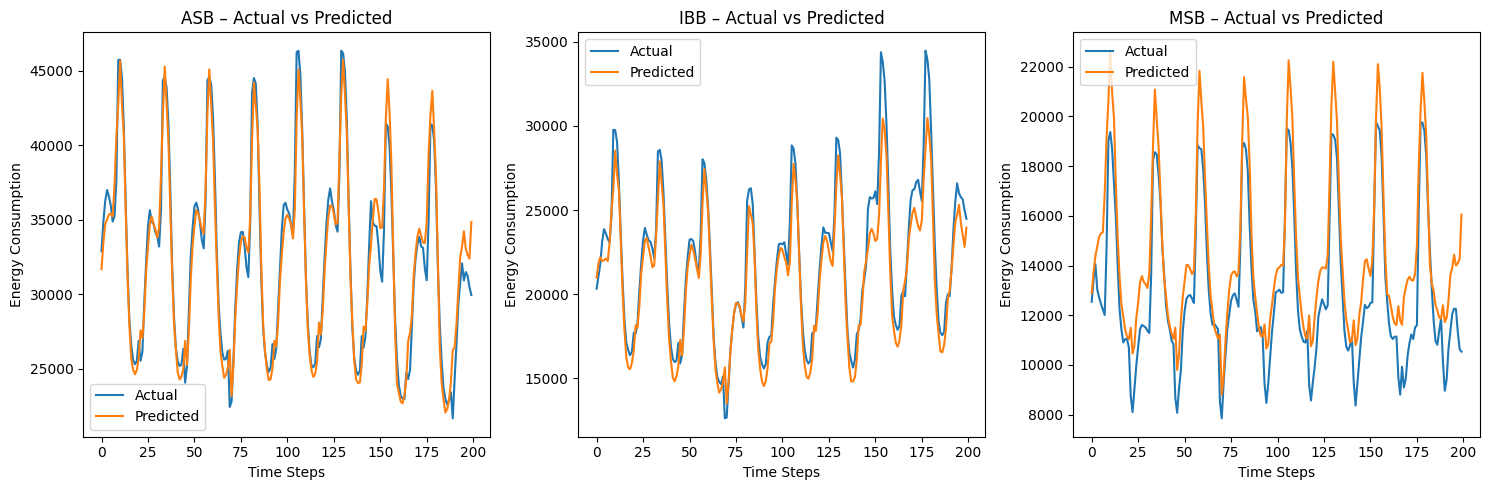

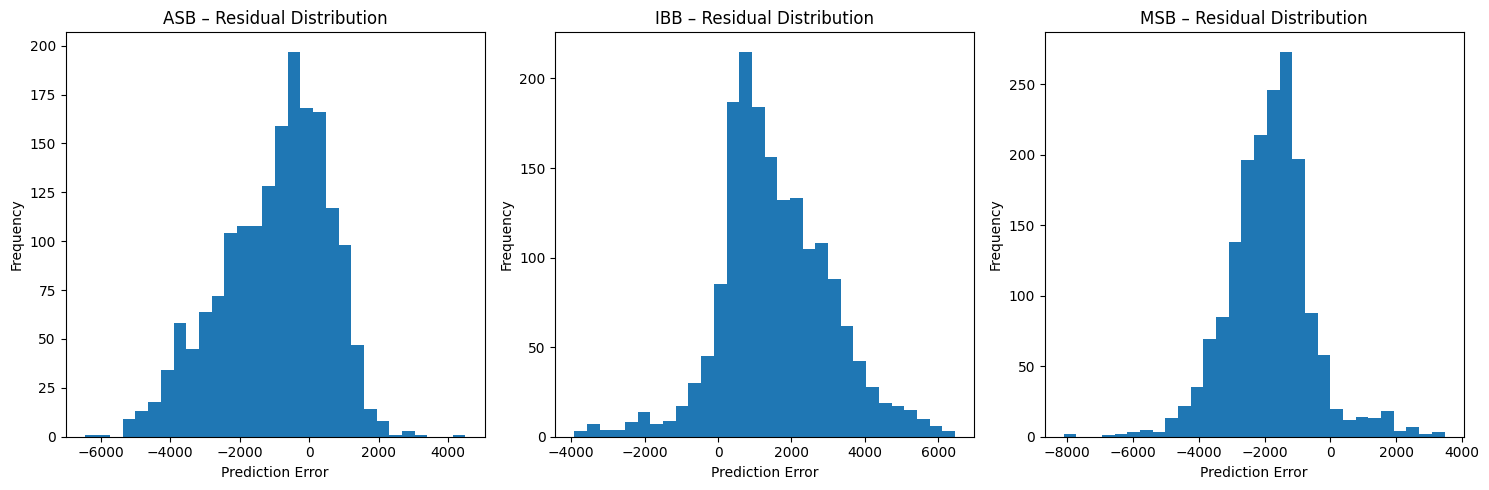

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

MODEL_PATH = "/content/drive/MyDrive/LSTM PAPER/lstm_bwo_final_model.keras"
X_TEST_PATH = "/content/drive/MyDrive/LSTM PAPER/X_test.npy"
Y_TEST_PATH = "/content/drive/MyDrive/LSTM PAPER/y_test.npy"
SCALER_PATH = "/content/drive/MyDrive/LSTM PAPER/target_scaler.save"

model = tf.keras.models.load_model(MODEL_PATH)

X_test = np.load(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)

target_scaler = joblib.load(SCALER_PATH)

y_pred_scaled = model.predict(X_test)

y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

labels = ["ASB", "IBB", "MSB"]

print("\nFINAL MODEL PERFORMANCE (TEST SET)\n")

for i, label in enumerate(labels):
    mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{label}")
    print(f"  MSE  : {mse:.6f}")
    print(f"  RMSE : {rmse:.6f}")
    print(f"  MAE  : {mae:.6f}")
    print(f"  R²   : {r2:.4f}")
    print("-" * 30)

plt.figure(figsize=(15,5))

for i, label in enumerate(labels):
    plt.subplot(1, 3, i+1)
    plt.plot(y_test_inv[:200, i], label="Actual")
    plt.plot(y_pred_inv[:200, i], label="Predicted")
    plt.title(f"{label} – Actual vs Predicted")
    plt.xlabel("Time Steps")
    plt.ylabel("Energy Consumption")
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))

for i, label in enumerate(labels):
    residuals = y_test_inv[:, i] - y_pred_inv[:, i]
    plt.subplot(1, 3, i+1)
    plt.hist(residuals, bins=30)
    plt.title(f"{label} – Residual Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

MODEL_PATH = "/content/drive/MyDrive/LSTM PAPER/lstm_bwo_final_model.keras"
X_TEST_PATH = "/content/drive/MyDrive/LSTM PAPER/X_test.npy"
Y_TEST_PATH = "/content/drive/MyDrive/LSTM PAPER/y_test.npy"
SCALER_PATH = "/content/drive/MyDrive/LSTM PAPER/target_scaler.save"

model = tf.keras.models.load_model(MODEL_PATH)

X_test = np.load(X_TEST_PATH)
y_test = np.load(Y_TEST_PATH)

target_scaler = joblib.load(SCALER_PATH)

y_pred_scaled = model.predict(X_test)

y_test_inv = target_scaler.inverse_transform(y_test)
y_pred_inv = target_scaler.inverse_transform(y_pred_scaled)

labels = ["ASB", "IBB", "MSB"]

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nFINAL MODEL PERFORMANCE (TEST SET)\n")

for i, label in enumerate(labels):
    mse = mean_squared_error(y_test_inv[:, i], y_pred_inv[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    r2 = r2_score(y_test_inv[:, i], y_pred_inv[:, i])
    mape_val = mape(y_test_inv[:, i], y_pred_inv[:, i])

    print(f"{label}")
    print(f"  MSE   : {mse:.4f}")
    print(f"  RMSE  : {rmse:.4f}")
    print(f"  MAE   : {mae:.4f}")
    print(f"  MAPE  : {mape_val:.2f}%")
    print(f"  R²    : {r2:.4f}")
    print("-" * 35)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

FINAL MODEL PERFORMANCE (TEST SET)

ASB
  MSE   : 3319599.6569
  RMSE  : 1821.9769
  MAE   : 1385.5341
  MAPE  : 4.70%
  R²    : 0.9111
-----------------------------------
IBB
  MSE   : 4718777.5243
  RMSE  : 2172.2747
  MAE   : 1762.8417
  MAPE  : 7.04%
  R²    : 0.8404
-----------------------------------
MSB
  MSE   : 5034207.5237
  RMSE  : 2243.7040
  MAE   : 1976.6156
  MAPE  : 17.32%
  R²    : 0.5291
-----------------------------------


**Persistence (Naïve) Model**

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test = np.load("/content/drive/MyDrive/LSTM PAPER/X_test.npy")
y_test = np.load("/content/drive/MyDrive/LSTM PAPER/y_test.npy")

y_pred_persistence = X_test[:, -1, -3:]

for i, label in enumerate(["ASB", "IBB", "MSB"]):
    mse = mean_squared_error(y_test[:, i], y_pred_persistence[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred_persistence[:, i])
    r2 = r2_score(y_test[:, i], y_pred_persistence[:, i])

    print(f"{label} Persistence Model")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-"*30)


ASB Persistence Model
MSE: 0.0040, MAE: 0.0476, R²: 0.8504
------------------------------
IBB Persistence Model
MSE: 0.0052, MAE: 0.0541, R²: 0.8657
------------------------------
MSB Persistence Model
MSE: 0.0011, MAE: 0.0221, R²: 0.8332
------------------------------


**Linear** Regression Baseline

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = np.load("/content/drive/MyDrive/LSTM PAPER/X_train.npy")
X_test = np.load("/content/drive/MyDrive/LSTM PAPER/X_test.npy")
y_train = np.load("/content/drive/MyDrive/LSTM PAPER/y_train.npy")
y_test = np.load("/content/drive/MyDrive/LSTM PAPER/y_test.npy")

X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)

model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train)

y_pred_lr = model_lr.predict(X_test_lr)

for i, label in enumerate(["ASB", "IBB", "MSB"]):
    mse = mean_squared_error(y_test[:, i], y_pred_lr[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred_lr[:, i])
    r2 = r2_score(y_test[:, i], y_pred_lr[:, i])

    print(f"{label} Linear Regression")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-"*30)


ASB Linear Regression
MSE: 0.0008, MAE: 0.0223, R²: 0.9687
------------------------------
IBB Linear Regression
MSE: 0.0012, MAE: 0.0244, R²: 0.9704
------------------------------
MSB Linear Regression
MSE: 0.0003, MAE: 0.0122, R²: 0.9498
------------------------------


**SVR**

In [ ]:
from sklearn.svm import SVR

models = {
    "ASB": SVR(kernel="rbf", C=100, gamma="scale"),
    "IBB": SVR(kernel="rbf", C=100, gamma="scale"),
    "MSB": SVR(kernel="rbf", C=100, gamma="scale")
}

y_pred_svr = np.zeros_like(y_test)

for i, label in enumerate(["ASB", "IBB", "MSB"]):
    svr = models[label]
    svr.fit(X_train_lr, y_train[:, i])
    y_pred_svr[:, i] = svr.predict(X_test_lr)

    mse = mean_squared_error(y_test[:, i], y_pred_svr[:, i])
    mae = mean_absolute_error(y_test[:, i], y_pred_svr[:, i])
    r2 = r2_score(y_test[:, i], y_pred_svr[:, i])

    print(f"{label} SVR")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    print("-"*30)


ASB SVR
MSE: 0.0022, MAE: 0.0374, R²: 0.9158
------------------------------
IBB SVR
MSE: 0.0091, MAE: 0.0763, R²: 0.7673
------------------------------
MSB SVR
MSE: 0.0050, MAE: 0.0650, R²: 0.2157
------------------------------


# CNN-LSTM WITH BWO OPTIMIZATION

**Import packages**

In [ ]:
import numpy as np
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



**Load Data**

In [ ]:
LOOKBACK = 24
HORIZON  = 1
X_train = np.load("/content/drive/MyDrive/LSTM PAPER/X_train.npy")
X_test = np.load("/content/drive/MyDrive/LSTM PAPER/X_test.npy")
y_train = np.load("/content/drive/MyDrive/LSTM PAPER/y_train.npy")
y_test = np.load("/content/drive/MyDrive/LSTM PAPER/y_test.npy")
X_train_seq = X_train
y_train_seq = y_train

X_test_seq  = X_test
y_test_seq  = y_test
print("X_train:", X_train_seq.shape)
print("y_train:", y_train_seq.shape)
print("X_test :", X_test_seq.shape)
print("y_test :", y_test_seq.shape)




X_train: (6969, 24, 8)
y_train: (6969, 3)
X_test : (1743, 24, 8)
y_test : (1743, 3)


**CNN LSTM Model**

In [ ]:
def build_cnn_lstm(lr, lstm_units, dropout):
    model = Sequential([
        Conv1D(
            filters=64,
            kernel_size=3,
            activation='relu',
            input_shape=(LOOKBACK, X_train_seq.shape[2])
        ),
        MaxPooling1D(pool_size=2),

        LSTM(lstm_units),
        Dropout(dropout),

        Dense(3)  # ASB, IBB, MSB
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse'
    )

    return model


**BWO**

In [ ]:
def BWO_optimization(pop_size=6, iterations=6):
    best_mse = float('inf')
    best_params = None

    for it in range(iterations):
        print(f"\nIteration {it+1}/{iterations}")

        for p in range(pop_size):
            lr = random.uniform(0.0001, 0.005)
            lstm_units = random.choice([32, 64, 128])
            dropout = random.uniform(0.1, 0.4)

            model = build_cnn_lstm(lr, lstm_units, dropout)

            model.fit(
                X_train_seq, y_train_seq,
                epochs=5,
                batch_size=32,
                verbose=0
            )

            preds = model.predict(X_test_seq, verbose=0)
            mse = mean_squared_error(y_test_seq, preds)

            print(f"  Candidate {p+1} → MSE: {mse:.5f}")

            if mse < best_mse:
                best_mse = mse
                best_params = {
                    "lr": lr,
                    "units": lstm_units,
                    "dropout": dropout
                }

    return best_params, best_mse


In [ ]:
best_params, best_mse = BWO_optimization()

print("\nBest Parameters Found:")
print(best_params)
print("Best Validation MSE:", best_mse)



Iteration 1/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00644


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00562


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00630


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00521


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.00574


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00907

Iteration 2/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00562


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00382


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00560


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00660


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.00433


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00658

Iteration 3/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00607


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00436


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00770


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00608


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.00712


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00555

Iteration 4/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00443


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00546


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00413


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00551


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.00696


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00526

Iteration 5/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00429


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00632


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00600


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00608


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.00575


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00597

Iteration 6/6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 1 → MSE: 0.00795


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 2 → MSE: 0.00536


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 3 → MSE: 0.00848


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 4 → MSE: 0.00398


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 5 → MSE: 0.01648


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Candidate 6 → MSE: 0.00554

Best Parameters Found:
{'lr': 0.002020954371294854, 'units': 128, 'dropout': 0.20716333467712975}
Best Validation MSE: 0.003819097159977087


**Final Model**

In [ ]:
final_model = build_cnn_lstm(
    lr=best_params["lr"],
    lstm_units=best_params["units"],
    dropout=best_params["dropout"]
)

history = final_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

final_model.save("/content/drive/MyDrive/LSTM PAPER/cnn_lstm_bwo_final_model.keras")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0267 - val_loss: 0.0037
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 12/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

In [ ]:
preds = final_model.predict(X_test_seq)

targets = ['ASB', 'IBB', 'MSB']

for i, name in enumerate(targets):
    mse  = mean_squared_error(y_test_seq[:, i], preds[:, i])
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_test_seq[:, i], preds[:, i])
    r2   = r2_score(y_test_seq[:, i], preds[:, i])

    print(f"\n{name}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"R²   : {r2:.4f}")


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

ASB
MSE  : 0.0035
RMSE : 0.0588
MAE  : 0.0513
R²   : 0.8699

IBB
MSE  : 0.0024
RMSE : 0.0489
MAE  : 0.0363
R²   : 0.9385

MSB
MSE  : 0.0024
RMSE : 0.0485
MAE  : 0.0415
R²   : 0.6294


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
y_test_seq shape: (1743, 3)
y_pred shape     : (1743, 3)


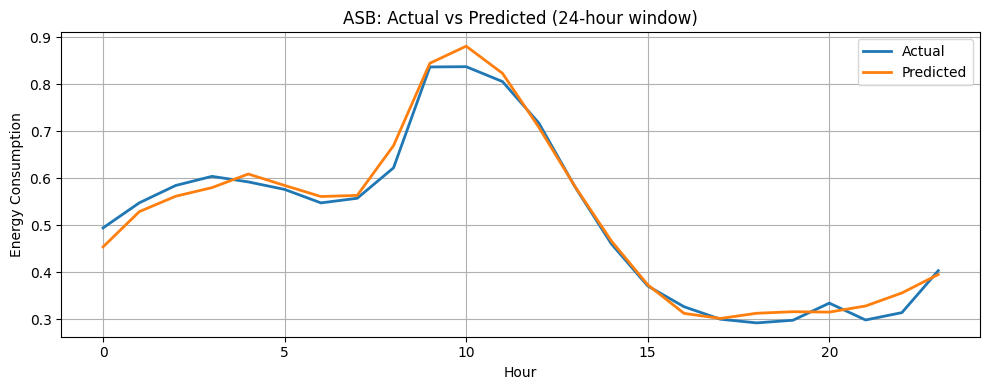

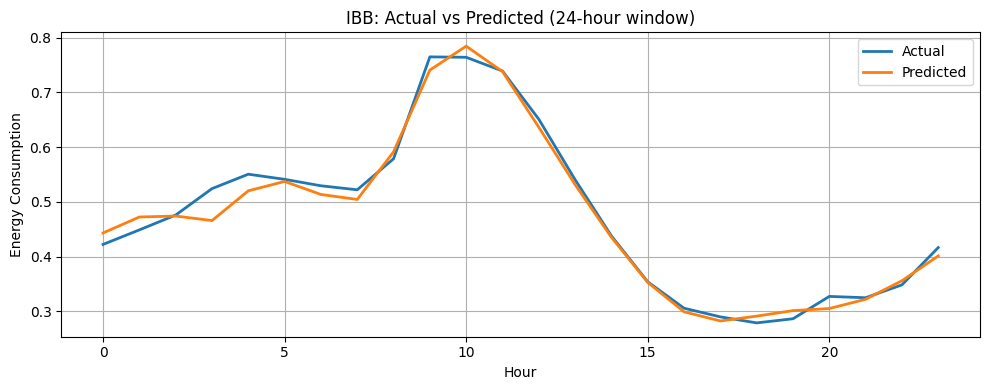

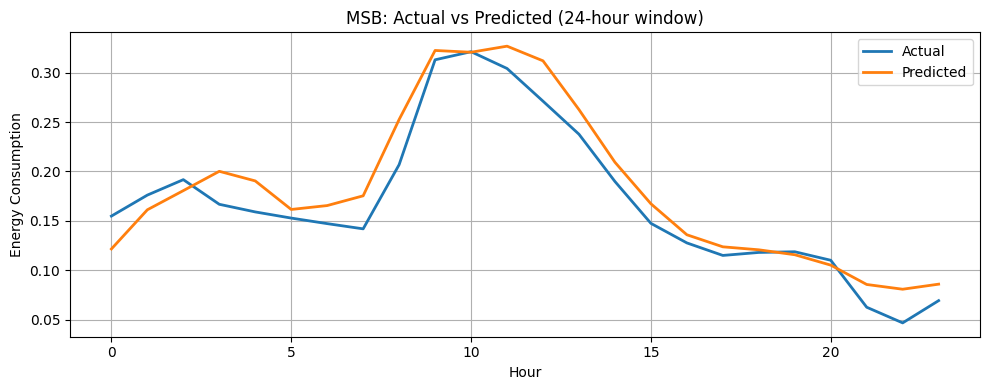

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

# 1. Load trained CNN + LSTM + BWO model
model = load_model("/content/drive/MyDrive/LSTM PAPER/cnn_lstm_bwo_final_model.keras")

# 2. Generate predictions on TEST SEQUENCES
y_pred = model.predict(X_test_seq)

# Safety check
print("y_test_seq shape:", y_test_seq.shape)
print("y_pred shape     :", y_pred.shape)

# 3. Plot settings
building_names = ["ASB", "IBB", "MSB"]

# Pick any continuous 24-hour window
start = 0
end = 24

# 4. Plot Actual vs Predicted
for i in range(3):
    plt.figure(figsize=(10,4))

    plt.plot(
        y_test_seq[start:end, i],
        label="Actual",
        linewidth=2
    )

    plt.plot(
        y_pred[start:end, i],
        label="Predicted",
        linewidth=2
    )

    plt.title(f"{building_names[i]}: Actual vs Predicted (24-hour window)")
    plt.xlabel("Hour")
    plt.ylabel("Energy Consumption")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.show()


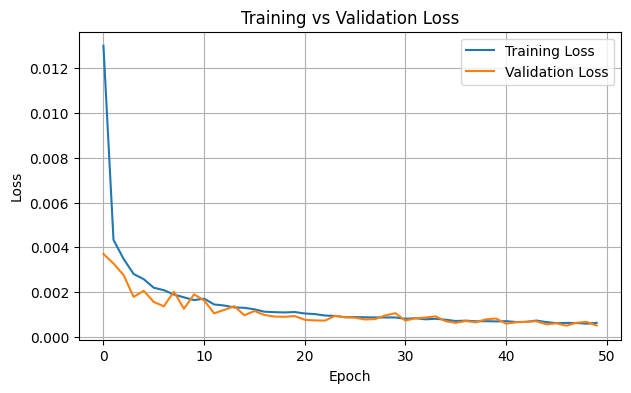

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


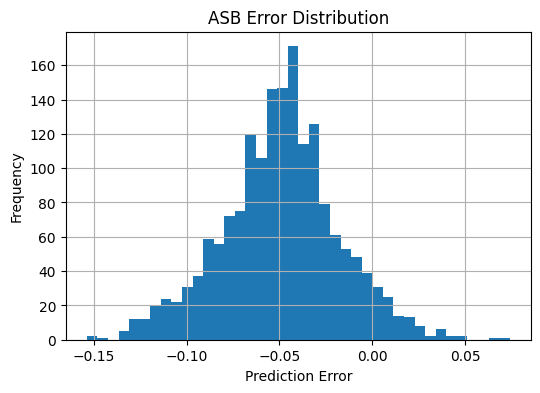

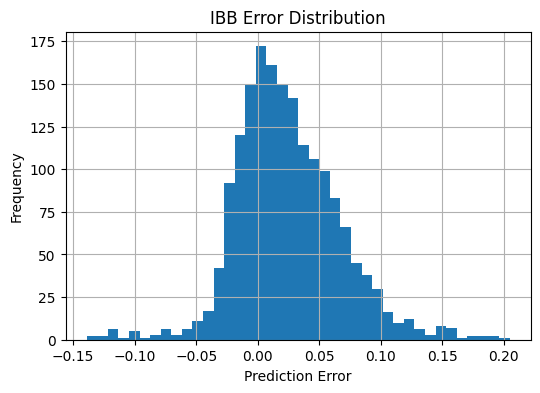

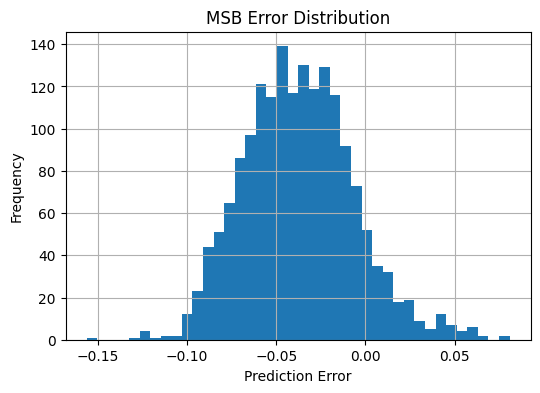

In [ ]:
errors = y_test - y_pred

for i in range(3):
    plt.figure(figsize=(6,4))
    plt.hist(errors[:, i], bins=40)

    plt.title(f"{building_names[i]} Error Distribution")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)

    plt.show()
